
# Exposure Time Calculator for TripleSpec at SOAR (v1.1)

This Jupyter Notebook provides an estimate of the expected S/N ratio of NIR spectroscopy using the [**TripleSpec**](https://noirlab.edu/science/programs/ctio/instruments/triplespec41-nir-imaging-spectrograph) instrument at the SOAR telescope.

**Author:** Felipe Navarete (felipe.navarete@noirlab.edu) <br>
**Date:** 2022 Jun 28

---
To plot the results, simply run: <br>
`tspec_etc(mag=10, texp=10, npix=5, nexp=1, frac=1.0, output=None))`

where:
- **mag** *(default=10)*: H-band magnitude
- **texp** *(default=100)*: exposure time (in seconds)
- **npix** *(default=5)*: number of pixels integrated along the slit
- **nexp** *(default=1)*: number of exposures 
- **frac** *(default=1.0)*: fraction of the exposures on time (*e.g.* ABBA sequence = 1.0, on-off-on = 0.7)
- **output** *(default=None)*: if provided, full path of output '.png' file of the results

---
**Requirements:**
- Astropy
- Matplotlib
- Numpy
---
**History:**
- 2022 Jun 28 (v1.1): add 'output' option, flag saturated pixels in red
- 2022 Jun 28 (v1.0): from xls spreadsheet ([1](https://noirlab.edu/science/programs/ctio/retired-instruments/ARCoIRIS/Instrument-Characteristics/ETC-Sensitivity)) to Python

---

## 1. Load the required packages
Run once to load the required packages

In [20]:
## Load packages
from   astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
print('Packages were loaded.')

Packages were loaded.


## 2. Function definitions
Run once to load the ETC function

In [43]:
def tspec_etc(mag=10, texp=10, npix=5, nexp=1, frac=1.0, output=None):
    """
      Main ETC function for TripleSpec
    """
    
    ReadNoise =  10.5 #  e-
    Gain      =	  1.1 #  e-/DN
    i_dark    =  0.01 #  e-/sec
    satur     = 90000 #  e- - limit for linearity regime up to 5%
    
    data = ascii.read("TripleSpec_ETC_input.dat", data_start=2)

    #  calculations
    etc_flux = frac * ( texp *      data['Cal']    * Gain ) * 10 ** ( ( 10 - mag ) / 2.5 )
    etc_bkg  = npix * ( texp * abs( data['Bkgrnd'] * Gain ) + ReadNoise**2 )
    
    # flag saturated pixels using single exposure case in DN
    idx_nlinear = etc_flux / frac > ( satur )
    
    #  obtain the SNR curve
    etc = np.sqrt(nexp) * etc_flux / np.sqrt( abs(etc_flux) + etc_bkg )
    
    #  plot results
    print(f'Input values: mag={mag} texp={texp} frac={frac} npix={npix} nexp={nexp}')
    plt.figure(figsize=(15,5))
    ax=plt.subplot()
    title='S/N vs lambda'
    xtitle = r'Wavelength ($\mu$m)'
    ytitle = 'S/N'
    
    #  flag non-linear or saturated pixels
    fl_nlin = None
    
    orders = range(3,8)
    
    for order in orders:
        pp = ( data['Order'] == order )
        nl = pp * idx_nlinear
        max_sn = np.max(etc[pp])
        ax.plot(data['Lambda'][pp], etc[pp], label=f'n={order} (SNRmax={max_sn:.1f})')
        
        #  flag non-linear or saturated pixels
        if sum(nl) > 0:
            label_nlinear = f'Pixels above non-linearity limit of 5%'
            if fl_nlin is not None: label_nlinear=''
            ax.plot(data['Lambda'][nl], etc[nl], 'x', color='red', label=label_nlinear)
            fl_nlin=1
    
    max_etc=np.max(etc)
    etc_ref = [50,100,150,200,250,300,500,1000]
    for vetc in etc_ref:
        if vetc < max_etc:
            ax.axhline(vetc, clip_on=True)
    
    ax.set_title(title)
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)

    ax.set_xlim([0.94,2.46])
    ax.set_ylim(bottom=0)
    ax.legend()

    plt.tight_layout()
    
    #  if provided, save the resuls as a '.png' file
    if output is not None:
        plt.savefig(output, format='png', dpi=300)
    plt.show()
    
    print('--------------------------------------------------------------------------------')

 

## 3. Playground
Now run the code by setting the desired instrumental setup. You can run several instances if wanted.

Input values: mag=10 texp=200 frac=1.0 npix=4 nexp=1


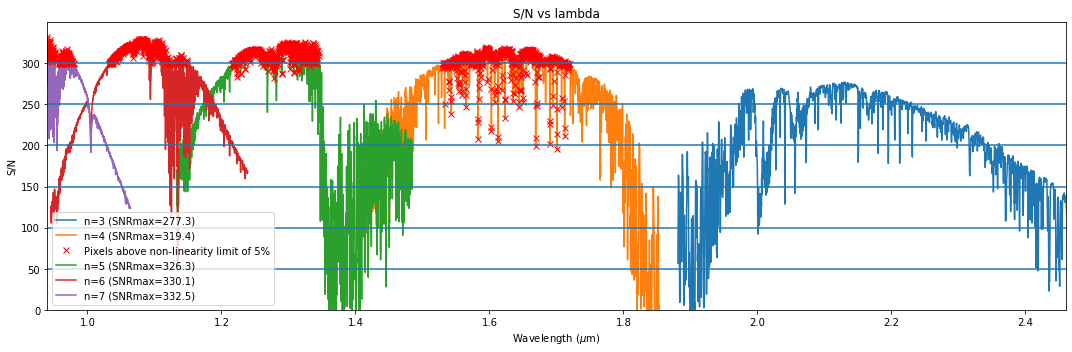

--------------------------------------------------------------------------------


In [45]:
tspec_etc(mag=10, texp=200, npix=4, nexp=1, frac=1.0, output=None)